<a href="https://colab.research.google.com/github/Gramani-Kumar/DL-Demo/blob/master/CIFAR10_VGG_with_Pretrained_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
#Lets download the data.
#Apply Transformation as well.

#Prepare Transformation.
myTransformObj = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#CIFAR10 is just 32x32 we've created transform to apply in each image.
# the transform ouput will be 224x224, normalized on each colour. 
# Mean on each channel applied to 0.5
# Standard diviation applied on each channel to 0.5


In [ ]:
import torchvision 
#Download the data and apply transformer.
trainset = torchvision.datasets.CIFAR10("myData",train = True, transform= myTransformObj, download=True)
testset = torchvision.datasets.CIFAR10("myData",train = False, transform= myTransformObj, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
tData = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
#testData = torch.utils.data.DataLoader(testset, )

In [ ]:
t = iter(tData)
img,label = t.next()

In [ ]:
img.shape

torch.Size([4, 3, 224, 224])

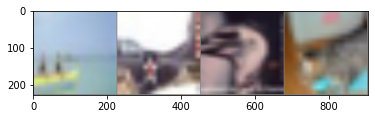

In [ ]:
t = torchvision.utils.make_grid(img)
t = t*.5 + .5 #Unnormalization.
plt.imshow(t.numpy().transpose(1, 2, 0))

In [ ]:
#Instantiate VGG16
import torchvision.models as models

In [ ]:
vgg16 = models.vgg16_bn(pretrained=True) #Load with pretrained weight

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
#Check the Structure.
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
import torch.nn as nn
#as per the last layer this network would classifies to 1000 clasess,
# but we want to have the network only for 10 classes.
# hence we need to modify the network to our need.

# There are multiple way we can modify 
# 1. simple one would be change the parameter once you creating the output.
vgg16_10 = models.vgg16(pretrained=True) #, num_classes=10) 

# Idea number 2: 
# Get the classifier list and modify only the last part.
input_feature = vgg16.classifier[6].in_features
modified_classifier = list(vgg16.classifier.children())[:-1]
#add the last layer.
modified_classifier.extend([nn.Linear(input_feature, 10)])

#change the classifier layer
#vgg16_10.classifier = nn.Sequential(*modified_classifier)

# Idea Number 3:
final_input_feature = vgg16_10.classifier[6].in_features
vgg16_10.classifier[6] = nn.Linear(final_input_feature, 10)
 

In [ ]:
#Get the GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
#Since we working on pretrained model we don't want any parameters to be trace for gradient
for param in vgg16_10.parameters():
  param.requires_grad = False

#Alter one more time the last classification layer so that it can be retrained.
#Unfroze the parameter.
final_input_feature = vgg16_10.classifier[6].in_features
vgg16_10.classifier[6] = nn.Linear(final_input_feature, 10)


In [ ]:
for param in vgg16_10.parameters():
  #if param.requires_grad :
  print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([10, 4096])
torch.Size([10])


In [ ]:
#import optim
import torch.optim as optim
vgg16_10 = vgg16_10.to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(vgg16_10.parameters(), lr=0.04) 